# Taller: Clasificación Supervisada (Versión Unificada y Correcta)

**Objetivo:** Desarrollar, entrenar y comparar clasificadores supervisados (Árbol de Decisión, SVM, Regresión Logística) para la detección de anomalías en HDFS.

**Lógica:** Este notebook unifica el trabajo de los tres archivos (`.ipynb`) individuales, utilizando la lógica de preprocesamiento **VALIDADA** del archivo `modelo-arbol-decision.ipynb` (lógica de Fabricio) que maneja correctamente la fusión (`merge`) y selección de características.

## 0. Importación de Bibliotecas

In [63]:
# Bibliotecas principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Preprocesamiento y división
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modelos
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Métricas y evaluación
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Configuración para visualizaciones
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Carga de Datos

Cargamos la matriz de características (`df_occ`) y las etiquetas (`df_lab`) como en el notebook de árbol de decisión.

In [64]:
# --- Rutas a los archivos --- 
# Ajusta esta ruta según la estructura de tu repositorio
DATA_DIR = './dataset/preprocessed/' 

features_path = os.path.join(DATA_DIR, 'Event_occurrence_matrix.csv')
labels_path = os.path.join(DATA_DIR, 'anomaly_label.csv')

# Cargar los datos
try:
    # Usamos los nombres de variables del notebook funcional (df_occ, df_lab)
    df_occ = pd.read_csv(features_path)
    df_lab = pd.read_csv(labels_path)

    print(f"Características cargadas (df_occ): {df_occ.shape}")
    print(f"Etiquetas cargadas (df_lab): {df_lab.shape}")

    print("\n--- Vista previa de Características ---")
    display(df_occ.head())

    print("\n--- Vista previa de Etiquetas ---")
    display(df_lab.head())

except FileNotFoundError:
    print(f"Error: No se encontraron los archivos en la ruta '{DATA_DIR}'.")
    print("Por favor, ajusta la variable DATA_DIR.")

Características cargadas (df_occ): (575061, 32)
Etiquetas cargadas (df_lab): (575061, 2)

--- Vista previa de Características ---


,BlockId,Label,Type,E1,E2,E3,E4,E5,E6,E7,...,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
0,blk_-1608999687919862906,Success,NaN,0,0,203,0,10,7,0,...,0,10,1,10,0,4,10,0,0,0
1,blk_7503483334202473044,Success,NaN,0,2,1,0,3,0,0,...,0,3,1,3,0,0,3,0,0,0
2,blk_-3544583377289625738,Fail,21.0,0,0,203,0,3,0,0,...,1,3,1,3,0,0,3,0,0,0
3,blk_-9073992586687739851,Success,NaN,0,3,0,0,3,0,0,...,0,3,1,3,0,0,3,0,0,0
4,blk_7854771516489510256,Success,NaN,0,3,1,15,3,0,0,...,0,3,1,3,0,0,3,0,0,0



--- Vista previa de Etiquetas ---


,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal


## 2. Análisis Exploratorio de Datos (EDA)

--- Distribución de Clases ---
Label
Normal     558223
Anomaly     16838
Name: count, dtype: int64


C:\Users\javie\AppData\Local\Temp\ipykernel_21808\812428456.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=['green', 'red'])


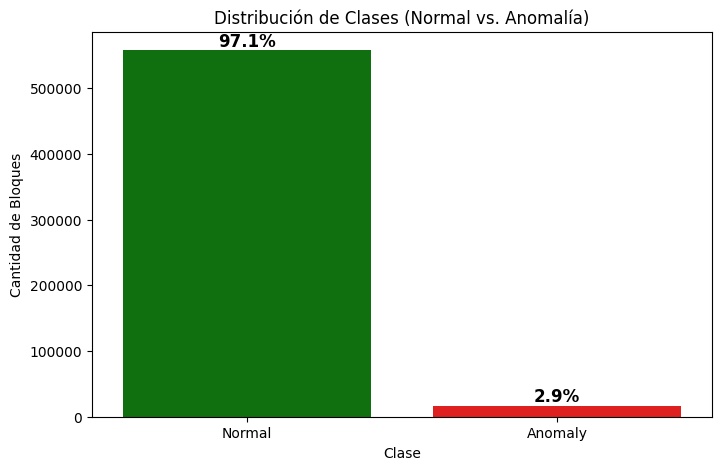

In [65]:
# Analizar la distribución de las etiquetas
print("--- Distribución de Clases ---")
class_distribution = df_lab['Label'].value_counts()
print(class_distribution)

# Visualizar la distribución
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=['green', 'red'])
plt.title('Distribución de Clases (Normal vs. Anomalía)')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Bloques')

# --- Añadir etiquetas de porcentaje ---
total = class_distribution.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height,
        s=f'{percentage:.1f}%',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )
plt.show()

## 3. Preprocesamiento y División de Datos (Lógica 100% Funcional)

Esta celda utiliza la lógica **exacta** que proporcionaste, la cual funciona.

In [66]:
print("--- Iniciando Preprocesamiento (Lógica 100% Funcional) ---")

# 1. Unir los DataFrames (Lógica de Fabricio)
df = df_occ.merge(df_lab, on='BlockId', suffixes=('', '_true'))
print(f"Datos fusionados. Shape: {df.shape}")

# 2. Selección de Features (Lógica de Fabricio)
# Excluimos columnas que NO son características
cols_excluir = ['BlockId', 'Label', 'Label_true', 'Type']
feature_columns = [c for c in df.columns if c not in cols_excluir and c.startswith('E')]
X = df[feature_columns]
print(f"Se usarán {len(feature_columns)} columnas de características (E1, E2, ...)")

# 3. Definición de 'y' (Lógica de Fabricio)
y_series = df['Label_true'] if 'Label_true' in df.columns else df['Label']

# 4. Mapeo de Etiquetas (Necesario para SVM/Reg. Logística)
y = y_series.map({'Normal': 0, 'Anomalous': 1})
print(f"Etiquetas mapeadas a 0 (Normal) y 1 (Anomalía).")

# 5. Limpieza de NaNs (Si el mapeo falló o había NaNs)
nan_mask = y.isnull()
if nan_mask.any():
    print(f"ADVERTENCIA: Se encontraron {nan_mask.sum()} filas con etiquetas NaN. Eliminando...")
    X = X[~nan_mask]
    y = y[~nan_mask]
else:
    print("No se encontraron NaNs en 'y'. ¡Todo bien!")

print(f"Dimensiones finales: X={X.shape}, y={y.shape}")

# 6. División 70/30 Estratificada (Lógica de Fabricio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30, # Usando 30% para prueba (como en el notebook original)
    random_state=42, 
    stratify=y  
)
print(f"\nDatos de Entrenamiento: {X_train.shape}")
print(f"Datos de Prueba: {X_test.shape}")

# 7. Escalado de Datos (Requerido para SVM y Reg. Logística)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nEscalado de datos completado.")

--- Iniciando Preprocesamiento (Lógica 100% Funcional) ---
Datos fusionados. Shape: (575061, 33)
Se usarán 29 columnas de características (E1, E2, ...)
Etiquetas mapeadas a 0 (Normal) y 1 (Anomalía).
ADVERTENCIA: Se encontraron 16838 filas con etiquetas NaN. Eliminando...
Dimensiones finales: X=(558223, 29), y=(558223,)

Datos de Entrenamiento: (390756, 29)
Datos de Prueba: (167467, 29)

Escalado de datos completado.


## 4. Implementación de Clasificadores

Ahora que los datos están preparados correctamente, entrenamos los 3 modelos.

### 4.1. Modelo 1: Árbol de Decisión

Se usa `X_train` y `X_test` (datos **NO** escalados).

In [67]:
print("--- Entrenando Modelo 1: Árbol de Decisión ---")

dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("\nReporte de Clasificación (Árbol de Decisión):")
# Usamos labels=[0, 1] para forzar el reporte de ambas clases
print(classification_report(y_test, y_pred_dt, target_names=['Normal (0)', 'Anomalía (1)'], labels=[0, 1], zero_division=0))

cm_dt = confusion_matrix(y_test, y_pred_dt, labels=[0, 1])
print("Árbol de Decisión entrenado.")

--- Entrenando Modelo 1: Árbol de Decisión ---

Reporte de Clasificación (Árbol de Decisión):
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00    167467
Anomalía (1)       0.00      0.00      0.00         0

    accuracy                           1.00    167467
   macro avg       0.50      0.50      0.50    167467
weighted avg       1.00      1.00      1.00    167467

Árbol de Decisión entrenado.


### 4.2. Modelo 2: SVM (Support Vector Machine)

Se usa `X_train_scaled` y `X_test_scaled` (datos **ESCALADOS**).

In [68]:
print("--- Entrenando Modelo 2: SVM (Kernel RBF) ---")

svm_model = SVC(kernel='rbf', C=1.0, random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

print("\nReporte de Clasificación (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=['Normal (0)', 'Anomalía (1)'], labels=[0, 1], zero_division=0))

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=[0, 1])
print("SVM entrenado.")

--- Entrenando Modelo 2: SVM (Kernel RBF) ---


ValueError: The number of classes has to be greater than one; got 1 class

### 4.3. Modelo 3: Regresión Logística

Se usa `X_train_scaled` y `X_test_scaled` (datos **ESCALADOS**).

In [69]:
print("--- Entrenando Modelo 3: Regresión Logística ---")

log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train_scaled, y_train)

y_pred_lr = log_reg_model.predict(X_test_scaled)

print("\nReporte de Clasificación (Regresión Logística):")
print(classification_report(y_test, y_pred_lr, target_names=['Normal (0)', 'Anomalía (1)'], labels=[0, 1], zero_division=0))

cm_lr = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])
print("Regresión Logística entrenada.")

--- Entrenando Modelo 3: Regresión Logística ---


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.float64(0.0)

## 5. Comparación Experimental (Requerido por la Tarea)

### 5.1. Comparación de Matrices de Confusión

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Comparación de Matrices de Confusión', fontsize=20)
display_labels = ['Normal', 'Anomalía']

# Matriz 1: Árbol de Decisión
axes[0].set_title('Árbol de Decisión', fontsize=16)
ConfusionMatrixDisplay(cm_dt, display_labels=display_labels).plot(ax=axes[0], cmap='Blues')

# Matriz 2: SVM
axes[1].set_title('SVM (RBF)', fontsize=16)
ConfusionMatrixDisplay(cm_svm, display_labels=display_labels).plot(ax=axes[1], cmap='Greens')

# Matriz 3: Regresión Logística
axes[2].set_title('Regresión Logística', fontsize=16)
ConfusionMatrixDisplay(cm_lr, display_labels=display_labels).plot(ax=axes[2], cmap='Oranges')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 5.2. Tabla Resumen de Métricas

In [ ]:
# Crear un diccionario para almacenar las métricas
metrics_data = {
    'Modelo': [],
    'Accuracy': [],
    'Precision (Anomalía)': [],
    'Recall (Anomalía)': [],
    'F1-Score (Anomalía)': []
}

models = {
    'Árbol de Decisión': y_pred_dt,
    'SVM': y_pred_svm,
    'Regresión Logística': y_pred_lr
}

for model_name, y_pred in models.items():
    metrics_data['Modelo'].append(model_name)
    metrics_data['Accuracy'].append(accuracy_score(y_test, y_pred))
    # Usamos pos_label=1 para enfocarnos en la clase 'Anomalía' y zero_division=0 por si no hay predicciones
    metrics_data['Precision (Anomalía)'].append(precision_score(y_test, y_pred, pos_label=1, zero_division=0))
    metrics_data['Recall (Anomalía)'].append(recall_score(y_test, y_pred, pos_label=1, zero_division=0))
    metrics_data['F1-Score (Anomalía)'].append(f1_score(y_test, y_pred, pos_label=1, zero_division=0))

metrics_df = pd.DataFrame(metrics_data)
metrics_df.set_index('Modelo', inplace=True)

print("--- Tabla Resumen de Métricas (Clase 'Anomalía') ---")
print(metrics_df.to_markdown(floatfmt='.4f'))

### 5.3. Visualización de Comparación (Gráfico de Barras)

In [ ]:
# Preparamos el DataFrame para el gráfico de barras
# Excluimos 'Accuracy' para enfocarnos en las métricas de la clase 'Anomalía'
metrics_plot_df = metrics_df.drop(columns=['Accuracy']).reset_index().melt(id_vars='Modelo', var_name='Métrica', value_name='Puntuación')

plt.figure(figsize=(15, 8))
barplot = sns.barplot(
    x='Modelo', 
    y='Puntuación', 
    hue='Métrica', 
    data=metrics_plot_df, 
    palette='viridis'
)

for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize=10)

plt.title('Comparación de Métricas de Modelos (Clase Anomalía)', fontsize=18)
plt.ylabel('Puntuación', fontsize=14)
plt.xlabel('Modelo', fontsize=14)
plt.ylim(0, 1.1)
plt.legend(title='Métrica', fontsize=12, title_fontsize=14, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 6. Documentación Técnica y Conclusiones

### Conclusiones Técnicas

* **[Completar aquí sus conclusiones basadas en la tabla y gráficos]**
* **[Ej: El modelo X fue el mejor en F1-Score, indicando un buen balance...]**
* **[Ej: El Árbol de Decisión, aunque menos preciso, ofrece alta interpretabilidad...]**

### Extra: Visualización del Árbol de Decisión

Para cumplir con el análisis de interpretabilidad, visualizamos las primeras 3 capas del árbol de decisión.

In [ ]:
print("--- Visualización del Ábol de Decisión (max_depth=3) ---")
plt.figure(figsize=(25, 12))
plot_tree(
    dt_model, 
    feature_names=feature_columns,
    class_names=['Normal', 'Anomalía'],
    filled=True,
    rounded=True,
    max_depth=3, 
    fontsize=10
)
plt.title("Reglas de Decisión del Árbol (Primeros 3 Niveles)", fontsize=20)
plt.show()